In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import sklearn
from sklearn.datasets import make_sparse_coded_signal
from sklearn.decomposition import DictionaryLearning, MiniBatchDictionaryLearning
from sklearn.utils import check_random_state

from scipy.spatial.distance import cdist
from decimal import Decimal

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def perm_free_D(D):
    D_temp = np.copy(D)
    for i in range(D_temp.shape[1]):
        D_temp[:,i]*=np.sign( np.sum(D_temp[:,i]) )

    col_sums=[np.sum(D_temp[:,i]) for i in range(D_temp.shape[1])]
    idx=list(range(D_temp.shape[1]))
    new_idx=np.argsort(col_sums)[::-1]
    D_new=D_temp[:,new_idx]    
    return D_new

def perm_free_DS(D, X):
    D_temp = np.copy(D)
    X_temp = np.copy(X)
    for i in range(D_temp.shape[1]):
        X_temp[i,:]*=np.sign( np.sum(D_temp[:,i]) )
        D_temp[:,i]*=np.sign( np.sum(D_temp[:,i]) )

    col_sums=[np.sum(D_temp[:,i]) for i in range(D_temp.shape[1])]
    idx=list(range(D_temp.shape[1]))
    new_idx=np.argsort(col_sums)[::-1]

    D_new=D_temp[:,new_idx]

    X_temp=X_temp[new_idx,:]
    
    return (D_new, X_temp)

In [4]:
def make_sparse_coded_signal1(
    n_samples,
    *,
    n_components,
    n_features,
    n_nonzero_coefs,
    random_state=None,
    data_transposed="warn",
):
    """Generate a signal as a sparse combination of dictionary elements.
    Returns a matrix Y = DX, such that D is (n_features, n_components),
    X is (n_components, n_samples) and each column of X has exactly
    n_nonzero_coefs non-zero elements.
    Read more in the :ref:`User Guide <sample_generators>`.
    Parameters
    ----------
    n_samples : int
        Number of samples to generate.
    n_components : int
        Number of components in the dictionary.
    n_features : int
        Number of features of the dataset to generate.
    n_nonzero_coefs : int
        Number of active (non-zero) coefficients in each sample.
    random_state : int, RandomState instance or None, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    data_transposed : bool, default=True
        By default, Y, D and X are transposed.
        .. versionadded:: 1.1
    Returns
    -------
    data : ndarray of shape (n_features, n_samples) or (n_samples, n_features)
        The encoded signal (Y). The shape is `(n_samples, n_features)` if
        `data_transposed` is False, otherwise it's `(n_features, n_samples)`.
    dictionary : ndarray of shape (n_features, n_components) or \
            (n_components, n_features)
        The dictionary with normalized components (D). The shape is
        `(n_components, n_features)` if `data_transposed` is False, otherwise it's
        `(n_features, n_components)`.
    code : ndarray of shape (n_components, n_samples) or (n_samples, n_components)
        The sparse code such that each column of this matrix has exactly
        n_nonzero_coefs non-zero items (X). The shape is `(n_samples, n_components)`
        if `data_transposed` is False, otherwise it's `(n_components, n_samples)`.
    """
    generator = check_random_state(random_state)

    # generate dictionary
    D = generator.normal(size=(n_features, n_components), loc=0.0, scale=1.0)
    D /= np.sqrt(np.sum((D**2), axis=0))

    # generate code
    X = np.zeros((n_components, n_samples))
    for i in range(n_samples):
        idx = np.arange(n_components)
        generator.shuffle(idx)
        idx = idx[:n_nonzero_coefs]
        X[idx, i] = generator.normal(size=n_nonzero_coefs, loc=0.0, scale=1.0)

    # encode signal
    Y = np.dot(D, X)

    # transpose if needed
    if not data_transposed:
        Y, D, X = Y.T, D.T, X.T

    return map(np.squeeze, (Y, D, X))

In [5]:
def dict_reconstruction(Y, n_comp):
    dict_learner = DictionaryLearning(n_components=n_comp\
                                  , max_iter=1000, transform_alpha=0.1)
    XhatT = dict_learner.fit_transform(Y.T)
    (Dhat_, Xhat_) = perm_free_DS(dict_learner.components_.T, XhatT.T)
    return (Dhat_, Xhat_)

In [6]:
n_nonzero_coefs=10
n_comp=100
n_feat=50
n_samp = 10000

##### Default #######
# X, dictionary, code = make_sparse_coded_signal(
# n_samples=10, n_components=n_comp, n_features=20, n_nonzero_coefs=n_nonzero_coefs,random_state=42,
# )

####### custom #######
Y, D, X = make_sparse_coded_signal(
n_samples=n_samp, n_components=n_comp, n_features=n_feat, n_nonzero_coefs=n_nonzero_coefs)


# Online dictionary learning 

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import time
import importlib
from torch.utils.data import TensorDataset


# Hyper Parameters
EPOCH = 50
BATCH_SIZE = 256
LR = .5  # learning rate
MNT = 0.9   # momentum variable
DOWNLOAD_Dataset = True
N_TEST_IMG = 5
m = n_comp     # Dictionary Size

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
input_dim = n_feat
n_samples = n_samp
trainset=Y.T

my_y=np.array(list(trainset.reshape(n_samples,input_dim,-1)))
tensor_y = torch.Tensor(my_y) # transform to torch tensor
#tensor_y = torch.Tensor(my_y)

train_data = TensorDataset(tensor_y) # create your datset
#trainloader = DataLoader(my_dataset)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

In [9]:
import Dictionary_Model as modelDL

model = modelDL.DictLearn(input_dim, m).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MNT)
loss_func = nn.MSELoss()

In [10]:
import importlib
importlib.reload(modelDL)

# Training
Error = np.zeros((EPOCH,))
Nnz = np.zeros((EPOCH,))
Loss = np.zeros((EPOCH,))
N = trainset.shape[0]
DISPLAY_FREQ = 1 ; 
TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
t0 = time.perf_counter()
SC = 'IHT' # 'fista' or 'IHT'
K = n_nonzero_coefs         # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'
# K = (n_comp - n_nonzero_coefs)/n_comp         # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'
# K = 0.2         # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'

Err = []

In [11]:
model.W = torch.nn.Parameter(torch.tensor(D, dtype=torch.float))
for epoch in range(EPOCH):
    for step, (x) in enumerate(trainloader):
        b_x = (x.view(-1, input_dim)).type(torch.FloatTensor).to(device)   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, input_dim)).type(torch.FloatTensor).to(device)   # batch y, shape (batch, 28*28)

        decoded, encoded, errIHT = model(b_x,SC,K)
        
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        model.zero_grad()
        
        if SC == 'IHT': Loss[epoch] = Loss[epoch] + loss.data
        elif SC == 'fista': Loss[epoch] = Loss[epoch] + loss.data + K * np.sum(np.abs(encoded.cpu().numpy()))
        decoded = decoded.detach()
        err = np.linalg.norm( D - model.W.data.numpy() ,'fro')
        Error[epoch] = Error[epoch] + err#errIHT[-1]
        Err = np.append(Err,errIHT[-1])
        Nnz[epoch] = Nnz[epoch] + np.count_nonzero(encoded.cpu().numpy())/encoded.cpu().numpy().size
                
    Loss[epoch] /= len(trainloader.dataset)
    Error[epoch] /= (step+1)
    Nnz[epoch] /= (step+1)
    print('Epoch: %d\tError: %.2e\t\tTrain loss: %.2e\t\tNNZ/(1-sparsity): %.2e' % (epoch, Decimal(Error[epoch]), Decimal(Loss[epoch]), Decimal(Nnz[epoch])), end="\r")
    

In [12]:
def dict_reconstruction_online(Y, n_comp, n_nonzero_coefs, n_feat, n_samp):
    EPOCH = 50
    BATCH_SIZE = 256
    LR = .5  # learning rate
    MNT = 0.9   # momentum variable
    DOWNLOAD_Dataset = True
    N_TEST_IMG = 5
    m = n_comp     # Dictionary Size
    
    input_dim = n_feat
    n_samples = n_samp
    n_samples_test = 100
    trainset=Y.T[:n_samples]
    testset=Y.T[n_samples:]

    my_y=np.array(list(trainset.reshape(n_samples,input_dim,-1)))
    tensor_y = torch.Tensor(my_y) # transform to torch tensor
    #tensor_y = torch.Tensor(my_y)

    train_data = TensorDataset(tensor_y) # create your datset
    #trainloader = DataLoader(my_dataset)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)
    
    test_data = TensorDataset(tensor_y) # create your datset
    #trainloader = DataLoader(my_dataset)

    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                             shuffle=True, num_workers=2)

    model = modelDL.DictLearn(input_dim, m).to(device)
    model.W = torch.nn.Parameter(torch.tensor(D, dtype=torch.float))
    optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MNT)
    loss_func = nn.MSELoss()
    
    # Training
    Error = np.zeros((EPOCH,))
    Nnz = np.zeros((EPOCH,))
    Loss = np.zeros((EPOCH,))
    N = trainset.shape[0]
    DISPLAY_FREQ = 1 ; 
    TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
    t0 = time.perf_counter()
    SC = 'IHT' # 'fista' or 'IHT'
    K = n_nonzero_coefs         # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'
    # K = (n_comp - n_nonzero_coefs)/n_comp         # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'
    # K = 0.2         # sparsity parameter: float numer if 'fista' or cardinality constraint if 'IHT'
    Err = []
    
    # Test
    Error_ = 0
    Nnz_ = 0
    Loss_ = 0
    Err_ = []
    
    for epoch in range(EPOCH):
        for step, (x) in enumerate(trainloader):
            b_x = (x.view(-1, input_dim)).type(torch.FloatTensor).to(device)   # batch x, shape (batch, 28*28)
            b_y = (x.view(-1, input_dim)).type(torch.FloatTensor).to(device)   # batch y, shape (batch, 28*28)

            decoded, encoded, errIHT = model(b_x,SC,K)

            loss = loss_func(decoded, b_y)      # mean square error
            optimizer.zero_grad()               # clear gradients for this training step
            loss.backward()                     # backpropagation, compute gradients
            optimizer.step()                    # apply gradients
            model.zero_grad()

            if SC == 'IHT': Loss[epoch] = Loss[epoch] + loss.data
            elif SC == 'fista': Loss[epoch] = Loss[epoch] + loss.data + K * np.sum(np.abs(encoded.cpu().numpy()))
            decoded = decoded.detach()
            err = np.linalg.norm( (decoded-b_x).cpu().numpy() ,'fro') / np.linalg.norm( b_x.cpu().numpy() ,'fro')
            Error[epoch] = Error[epoch] + errIHT[-1]
            Err = np.append(Err,errIHT[-1])
            Nnz[epoch] = Nnz[epoch] + np.count_nonzero(encoded.cpu().numpy())/encoded.cpu().numpy().size

    #         # for debugging:
    #         print(Error[epoch]/(step+1))
    #         if step%50==0:
    #             plt.plot(errIHT); plt.show()

        Loss[epoch] /= len(trainloader.dataset)
        Error[epoch] /= (step+1)
        Nnz[epoch] /= (step+1)

    for step, (x) in enumerate(testloader):
        b_x = (x.view(-1, input_dim)).type(torch.FloatTensor).to(device)   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, input_dim)).type(torch.FloatTensor).to(device)   # batch y, shape (batch, 28*28)

        decoded, encoded, errIHT = model(b_x,SC,K)

        loss = loss_func(decoded, b_y)      # mean square error

        if SC == 'IHT': Loss_ = Loss_ + loss.data
        elif SC == 'fista': Loss_ = Loss_ + loss.data + K * np.sum(np.abs(encoded.cpu().numpy()))
        decoded = decoded.detach()
        err = np.linalg.norm( (decoded-b_x).cpu().numpy() ,'fro') / np.linalg.norm( b_x.cpu().numpy() ,'fro')
        Error_ = Error_ + errIHT[-1]
        Err_ = np.append(Err_,errIHT[-1])
        Nnz_ = Nnz_ + np.count_nonzero(encoded.cpu().numpy())/encoded.cpu().numpy().size

    Loss_ /= len(testloader.dataset)
    Error_ /= (step+1)
    Nnz_ /= (step+1)

    return (model, Loss[-1], Loss_.data.numpy())

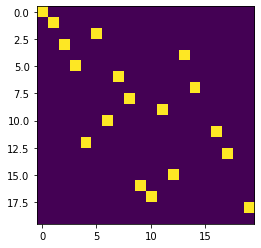

10  -  0.007810232919766662 3.434739075601101e-06 1.0730133362812922e-05


In [13]:
N = 20
M = 20
EPOCH = 50
rho = 0.4
P = 100

error = []
for M in [10]:

    Y, D, X = make_sparse_coded_signal(
    n_samples=P + 100, n_components=N, n_features=M, n_nonzero_coefs=int(rho * N))

    # Random undersample
    (D_, X_) = perm_free_DS(D, X)

    # Reconstruct
    (model, loss, loss_) = dict_reconstruction_online(Y, N, int(rho * N), M, P)
    Dhat = model.W.data.numpy()
    Dhat_ = perm_free_D(Dhat)
    temp = cdist(Dhat_.T, D_.T, 'cosine')
    temp_error = 0
    for atom_index in range(N):
        temp_error += np.min(temp[:, atom_index])

    plt.imshow(temp < 0.1)
    plt.show()
    print(np.around(M, decimals = 2), ' - ', temp_error/(M*N), loss/M, loss_/M)
    error.append(temp_error)

In [14]:
# N = 60
# M = 30
# EPOCH = 50
# rho = 0.1

# error = []
# for P in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]:
#     piter = 100
#     temp_error_ = []
#     for it in np.r_[:piter]:
#         Y, D, X = make_sparse_coded_signal(
#         n_samples=P+100, n_components=N, n_features=M, n_nonzero_coefs=int(rho * N))

#         # Random undersample
#         (D_, X_) = perm_free_DS(D, X)

#         # Reconstruct
#         (model, Dhat, loss) = dict_reconstruction_online(Y, N, int(rho * N), M, P)
#         Dhat_ = perm_free_D(Dhat)
#         temp = cdist(Dhat_.T, D_.T)
#         temp_error = 0
#         for atom_index in range(N):
#             temp_error += np.min(temp[atom_index, :])
#         temp_error_.append(temp_error)
#     error.append(np.percentile(np.array(temp_error_), q = 50))
#     print(error[-1])

# Dictionary learning phase curve

In [15]:
# Create a 128 x 128 phase transition matrix
phase_transition = np.zeros( (32,32) )
phase_transition_signal = np.zeros( (32,32) )
phase_transition_signal_test = np.zeros( (32,32) )

lamb = 0.05
niter = 30

# Loop delta and rho from 0 to 127 skipping 4
piter = 1
for it in np.r_[:piter]:
    for pi in tqdm(np.r_[1:32:1]):
        for rho in np.r_[1:32:1]:
            
            # Generate sparse signal
            Y, D, X = make_sparse_coded_signal(
            n_samples=1000+100, n_components=32, n_features=pi, n_nonzero_coefs=rho)

            # Random undersample
            D = D.reshape(pi, 32)
            Y = Y.reshape(pi, 1100)
            (D_, X_) = perm_free_DS(D, X)

            # Reconstruct
            (model, loss, loss_) = dict_reconstruction_online(Y, 32, rho, pi, 1000)
            Dhat = model.W.data.numpy().reshape(pi, 32)
            Dhat_ = perm_free_D(Dhat)
            temp = cdist(Dhat_.T, D_.T, 'cosine')
            temp_error = 0
            for atom_index in range(32):
                temp_error += np.min(temp[:, atom_index])

            # Assign error to phase_transition
            phase_transition[int(rho / 1), int(pi / 1)] += temp_error/(pi*32)
            phase_transition_signal[int(rho / 1), int(pi / 1)] += loss/(pi)
            phase_transition_signal_test[int(rho / 1), int(pi / 1)] += loss_/(pi)

phase_transition = phase_transition / piter
print("done")
        

100%|██████████| 31/31 [3:20:31<00:00, 388.10s/it]  

done


Text(0.5, 0, 'pi = P/N')

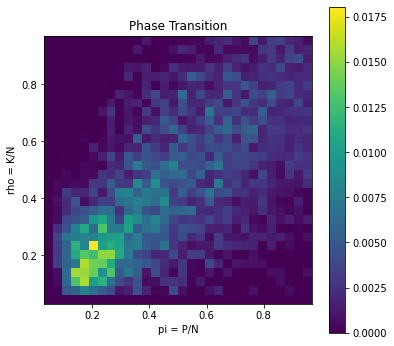

In [16]:
# Plot phase transition matrix
plt.figure(figsize=(6, 6))
plt.imshow(phase_transition[1:-1,1:-1], origin='lower',  extent = (0.03125, 1-0.03125, 0.03125, 1-0.03125))
plt.colorbar()
plt.title( 'Phase Transition' )
plt.ylabel('rho = K/N')
plt.xlabel('pi = P/N')

Idea (by Anirvan): Feed in the X that we obtain here into an autoencoder. 